# Lap time Rules

In this notebook, we will implement rules related to lap time predictions with three main strategies: 

1. **Optimal Performance Window Rule**
```
IF (predicted LapTime < current LapTime AND Position > 3 AND TyreAge < 8)
THEN recommend strategic push
CONFIDENCE: 0.75
```
This rule will identify opportunities for drivers to push harder when lap times are improving and tires are relatively fresh. Since position data may be limited, we'll implement a flexible approach:

* Make the position condition optional.

* Default to a reasonable assumption if position is unavailable.

* Use driver number as a proxy for position if necessary.

2. **Performance Cliff Detection Rule**

```
IF (predicted LapTime > current LapTime + 0.7 AND TyreAge > 15)
THEN recommend priority pit stop
CONFIDENCE: 0.85
```
This rule focuses on detecting significant performance drops that indicate a tire is reaching its limit, regardless of position data.

3. **Post-Traffic Recovery Rule**

``
IF (predicted LapTime < current LapTime - 0.5 AND Position changed negatively in last lap)
THEN recommend recovery stint
CONFIDENCE: 0.7`
``
For this rule, which requires position change data, we'll implement:

* A position change detection mechanism based on available data.

* A fallback mechanism that uses lap time increases as an indirect indicator of position loss.

* An option to disable this rule if position data is completely unavailable.

---

## 1. Importing Necessary Libraries

In [9]:
# Import standard Python libraries
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns            # For enhanced visualizations
from datetime import datetime    # For timestamp handling
import os                        # For operating system interactions
import sys                       # For system-specific parameters and functions

# Add parent directory to system path to make custom modules accessible
sys.path.append(os.path.abspath('../'))  

# Try importing the lap prediction module if available
try:
    # The lap prediction module contains functions for predicting lap times
    from ML_tyre_pred.ML_utils import N00_model_lap_prediction as lp
    print("Successfully imported lap prediction module")
except ImportError:
    # This warning appears if the module can't be found
    print("Warning: Could not import lap prediction module. Some functionality may be limited.")

# Import Experta components for building the rule engine
from experta import Rule, NOT, OR, AND, AS, MATCH, TEST, EXISTS  # Rule definition components
from experta import DefFacts, Fact, Field, KnowledgeEngine      # Core Experta classes

# Import custom fact classes and functions from previous notebooks
import utils.N01_agent_setup as agent_setup
from utils.N01_agent_setup import (
    TelemetryFact,              # For storing car performance data
    DegradationFact,            # For storing tire degradation information
    RaceStatusFact,             # For storing current race conditions
    StrategyRecommendation,     # For storing strategy recommendations
    F1StrategyEngine,           # Base engine class
    transform_lap_time_predictions,  # Function to convert predictions to facts
    load_lap_time_predictions        # Function to load lap time predictions
)

# Configure plotting style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')  # Set default plot style
sns.set_context("notebook", font_scale=1.2)  # Increase font size slightly

print("Libraries and fact classes loaded successfully.")

Successfully imported lap prediction module
Libraries and fact classes loaded successfully.


---

## 2. Data Analysis for Rule Thresholds

We need to:

1. Create a function to load and preprocess lap time data from a CSV file.

2. Calculate important metrics like lap time differences and position changes.

3. Analyze the distribution of lap time differences to find menaingful thresholds.

4. Create visualizations of lap time differences to understand what constitutes "significant" changes.

5. Analyze the relationship between tire age and lap time to determine when tires are fresh or old.

6. Set specific threshold values for our rules based on this data analysis.

This section is important because it will give us data-driven thresholds for our rules instead of just using arbitrary values. For example, we'll determine:

- What lap time difference indicates a performance cliff
- What improvement in lap time suggests a recovery opportunity
- What tire age should be considered "fresh" or "old"

### 2.1 Loading and Preprocessing lap times. Calculating important metrics.

In [10]:
def load_lap_time_data(file_path='../../outputs/week3/lap_prediction_data.csv'):
    """
    Load lap time data from file and preprocess it for threshold analysis
    
    Args:
        file_path: Path to CSV file with lap time data
        
    Returns:
        DataFrame with processed lap time data
    """
    # Load the data from CSV file
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    
    # Display information about available columns for debugging
    print(f"Available columns: {df.columns.tolist()}")
    
    # Convert float columns to integers where appropriate
    # This makes the data more consistent and easier to work with
    integer_columns = ['Position', 'TyreAge', 'DriverNumber', 'CompoundID', 'TeamID']
    for col in integer_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    # Sort data by driver and lap for consistency and to ensure
    # calculations of differences work correctly
    sort_columns = [col for col in ['DriverNumber', 'LapNumber', 'TyreAge'] if col in df.columns]
    df = df.sort_values(sort_columns)
    
    # Calculate lap time differences for each driver
    # This is crucial for our rules that look at improvements or slowdowns
    if 'LapTime' in df.columns:
        # Get the previous lap time for each driver
        df['PrevLapTime'] = df.groupby('DriverNumber')['LapTime'].shift(1)
        
        # Calculate the difference: positive = slower, negative = faster
        df['LapTimeDifference'] = df['LapTime'] - df['PrevLapTime']
        
        # Calculate position changes if position data is available
        if 'Position' in df.columns:
            # Get the previous position for each driver
            df['PrevPosition'] = df.groupby('DriverNumber')['Position'].shift(1)
            
            # Calculate position change: positive = improved, negative = lost positions
            # We subtract current from previous because lower position numbers are better
            df['PositionChange'] = df['PrevPosition'] - df['Position']
    
    return df



In [11]:
# Load the lap time data
lap_time_data = load_lap_time_data()

# Display a sample of the data to verify our preprocessing
print("Loaded lap time data (first 5 rows):")
print(lap_time_data.head())

Successfully loaded data from ../../outputs/week3/lap_prediction_data.csv
Available columns: ['Unnamed: 0', 'LapTime', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Position', 'LapsSincePitStop', 'DRSUsed', 'TeamID', 'CompoundID', 'TyreAge', 'FuelLoad', 'DriverNumber']
Loaded lap time data (first 5 rows):
    Unnamed: 0  LapTime  Stint  SpeedI1  SpeedI2  SpeedFL  SpeedST  Position  \
0            0   83.935    1.0    256.0    261.0    276.0    275.0         1   
1            1   80.402    1.0    252.0    257.0    276.0    295.0         1   
26          27   78.707    2.0    260.0    261.0    279.0    302.0         1   
2            2   80.499    1.0    249.0    256.0    276.0    297.0         1   
27          28   78.860    2.0    259.0    255.0    279.0    301.0         1   

    LapsSincePitStop  DRSUsed  TeamID  CompoundID  TyreAge  FuelLoad  \
0                1.0        0       9           2        1    0.9848   
1                2.0        0       9           2        2  

---

### 2.2 Analyze lap time distribution

#### 2.2.1 Analyzing lap time differences to determine thresholds for our rules


Statistics for lap time differences:
count    1160.000000
mean        0.002927
std         1.981962
min        -7.135000
25%        -1.359000
50%        -0.401000
75%         1.458750
max         7.222000
Name: LapTimeDifference, dtype: float64


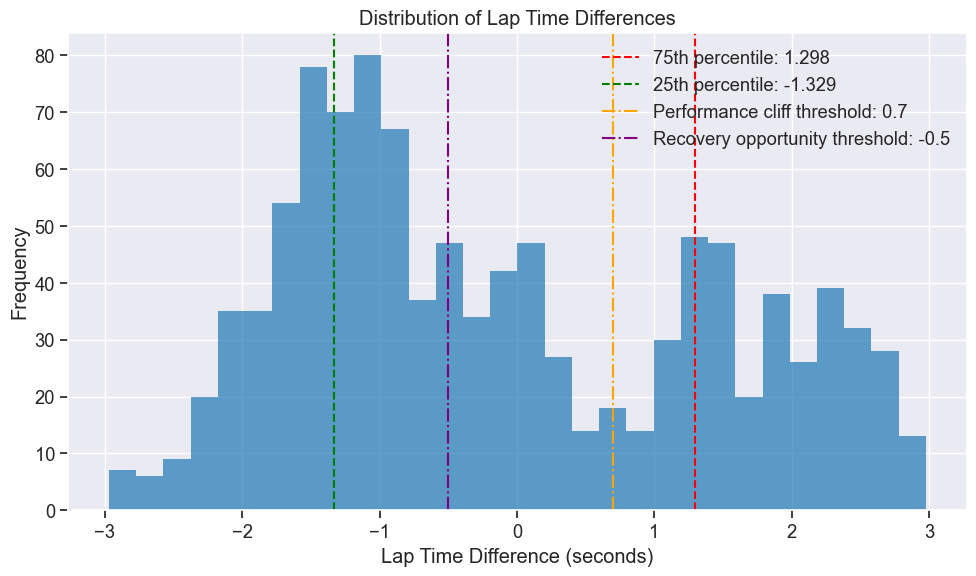


Suggested thresholds based on data distribution:
Performance Cliff Threshold: 1.874 seconds
Significant Improvement Threshold: -1.597 seconds

For our rules, we'll use:
- 0.7s for performance cliff (when lap time gets worse by 0.7s or more)
- -0.5s for recovery opportunity (when lap time improves by 0.5s or more)


In [12]:
# Analyze lap time differences to determine thresholds for our rules
if 'LapTimeDifference' in lap_time_data.columns:
    # First, get basic statistics about the lap time differences
    print("\nStatistics for lap time differences:")
    print(lap_time_data['LapTimeDifference'].describe())
    
    # Filter out extreme values that might skew our analysis
    # This gives us a more realistic distribution to work with
    reasonable_diffs = lap_time_data[
        (lap_time_data['LapTimeDifference'] > -3) & 
        (lap_time_data['LapTimeDifference'] < 3)
    ]['LapTimeDifference']
    
    # Create a histogram to visualize the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(reasonable_diffs, bins=30, alpha=0.7)
    
    # Add lines for important percentiles to help identify thresholds
    plt.axvline(reasonable_diffs.quantile(0.75), color='r', linestyle='--', 
               label=f'75th percentile: {reasonable_diffs.quantile(0.75):.3f}')
    plt.axvline(reasonable_diffs.quantile(0.25), color='g', linestyle='--',
               label=f'25th percentile: {reasonable_diffs.quantile(0.25):.3f}')
    
    # Add our proposed thresholds for the rules
    plt.axvline(0.7, color='orange', linestyle='-.',
               label='Performance cliff threshold: 0.7')
    plt.axvline(-0.5, color='purple', linestyle='-.',
               label='Recovery opportunity threshold: -0.5')
    
    plt.xlabel('Lap Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lap Time Differences')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate suggested thresholds based on data percentiles
    # 85th percentile for performance cliff (significant slowdown)
    performance_cliff_threshold = reasonable_diffs.quantile(0.85)
    # 15th percentile for significant improvement
    improvement_threshold = reasonable_diffs.quantile(0.15)
    
    print(f"\nSuggested thresholds based on data distribution:")
    print(f"Performance Cliff Threshold: {performance_cliff_threshold:.3f} seconds")
    print(f"Significant Improvement Threshold: {improvement_threshold:.3f} seconds")
    print(f"\nFor our rules, we'll use:")
    print(f"- 0.7s for performance cliff (when lap time gets worse by 0.7s or more)")
    print(f"- -0.5s for recovery opportunity (when lap time improves by 0.5s or more)")
else:
    print("LapTimeDifference column not available in the data.")



#### 2.2.2 Analyze relationship between tire age and lap time

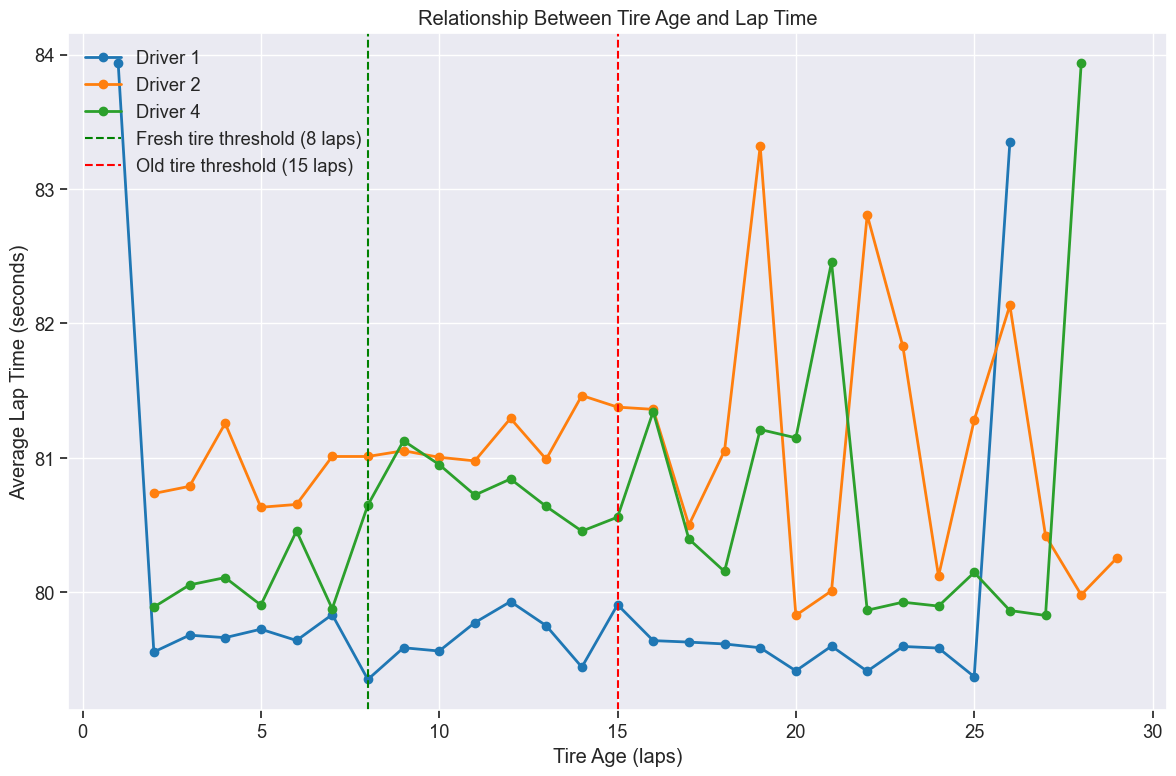


Tire age thresholds for our rules:
- Fresh tires: Less than 8 laps
- Old tires: More than 15 laps

Note: These thresholds are based on typical F1 tire performance patterns.
Different compounds and track conditions may shift these values.


In [13]:
# analyze the relationship between tire age and lap time
if 'TyreAge' in lap_time_data.columns and 'LapTime' in lap_time_data.columns:
    # Get a few sample drivers to visualize
    sample_drivers = sorted(lap_time_data['DriverNumber'].unique())[:3]
    
    # Create a plot showing how lap time changes with tire age
    plt.figure(figsize=(12, 8))
    
    for driver in sample_drivers:
        driver_data = lap_time_data[lap_time_data['DriverNumber'] == driver]
        
        # Group by TyreAge and calculate mean lap time
        # This smooths out individual variations and shows the trend
        tire_vs_lap = driver_data.groupby('TyreAge')['LapTime'].mean().reset_index()
        
        plt.plot(tire_vs_lap['TyreAge'], tire_vs_lap['LapTime'], 'o-', linewidth=2,
                label=f'Driver {driver}')
    
    # Add lines for our tire age thresholds
    plt.axvline(x=8, color='g', linestyle='--', 
               label='Fresh tire threshold (8 laps)')
    plt.axvline(x=15, color='r', linestyle='--',
               label='Old tire threshold (15 laps)')
    
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Average Lap Time (seconds)')
    plt.title('Relationship Between Tire Age and Lap Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print("\nTire age thresholds for our rules:")
    print("- Fresh tires: Less than 8 laps")
    print("- Old tires: More than 15 laps")
    print("\nNote: These thresholds are based on typical F1 tire performance patterns.")
    print("Different compounds and track conditions may shift these values.")
else:
    print("TyreAge or LapTime columns not available in the data.")

#### Conclussions of both charts.

**Lap Time Differences Distribution (Chart 1)**

- *Bimodal Distribution*: The histogram shows two distinct peaks - one for improvements (negative values) and one for slowdowns (positive values).
- *Wide Range*: Lap times can vary significantly, from -7.13s to +7.22s, but most changes are within ±3 seconds.

- *Data-Driven vs. Chosen Thresholds*: The statistical analysis suggests quite extreme thresholds (1.87s for cliff, -1.60s for improvement), but we've chosen more conservative values (0.7s and -0.5s) that will trigger earlier.

- *Strategic Choice*: Our selected thresholds are more conservative than the data's percentiles, allowing us to detect performance changes before they become extreme.


**Tire Age vs. Lap Time (Image 2)**

- *Driver Variability:* Each driver shows different patterns of tire performance, with Driver 1 (blue) generally faster.

- *Non-Linear Degradation:* The relationship between tire age and lap time isn't strictly linear - we see periods of stable performance followed by sudden changes.

- *Performance Cliff:* Beyond 15 laps, we see more variability and some performance spikes, supporting our "old tire" threshold.

- *Initial Improvement:* Tires often perform better after a few laps of warm-up, which supports our fresh tire threshold of 8 laps.

#### Lets move on to the next section: 

---

## 3. Implementing Lap time Rules

The `F1LapTimeRules` class will inherit from `F1StrategyEngine`, defined in `N01_agent_setup.py/ipynb`.

This class will implement the three core rules for lap time concerns, using our XGboost that predicts lap times.

- `optimal_performance_window`: o identify when drivers should push harder.

- `performance_cliff_detection`: to detect when tires are reaching their performance limit.

- `post_traffic_recovery`: to identify opportunities to recover time after trafic.

In [14]:
class F1LapTimeRules(F1StrategyEngine):
    """
    Engine implemting lap time related rules for F1 Strategy.


    This class extends the base F1StrategyEngine to add rules that analyze lap time patterns and identify strategic opportunities based on:
        - Improving lap times with fresh tyres.
        - Detecting performance cliffs when tires degrade.
        - Identifying recovery opportunities after traffic.
    
    The rules use the thresholds established in our data analysis.
    """



    ##################################### RULE 1: Improving lap times with fresh tires.
    @Rule(
        # Match and capture the current lap time
        TelemetryFact(lap_time = MATCH.lap_time),

        # Match and capture the predicted lap time
        TelemetryFact(predicted_lap_time = MATCH.predicted_lap_time),


        # Test if predicted lap time is faster than current (improvement)
        TEST(lambda lap_time, predicted_lap_time:
             lap_time is not None and 
             predicted_lap_time is not None and float(predicted_lap_time) < float(lap_time)),

        # Match and capture the current position 
        TelemetryFact(position = MATCH.position),

        # Test if posiiton is outside podium (not in top 3)
        TEST(lambda position : position > 3),

        # Match and capture the tire age
        TelemetryFact(tire_age = MATCH.tire_age),

        # Test if tires are relatively fresh (< 8 laps)
        TEST(lambda tire_age : int(tire_age) < 8),


        # Capture current Lap for the recommendation
        RaceStatusFact(lap = MATCH.lap)

        )
    def optimal_performance_window(self, lap_time, predicted_lap_time, position, tire_age, lap):
        """
        Rule 1: Optimal Performance Window
        
        Identifies opportunities for a driver to push harder when:
        - Lap times are improving (predicted time is faster than current)
        - The car is not in a podium position (P4 or lower)
        - Tires are relatively fresh (less than 8 laps old)
        
        This rule targets situations where a car has good pace but isn't
        in a podium position yet, suggesting the driver can push harder.
        
        """
        # Debug output to show rule activation and conditions
        print(f"Rule activated: optimal_performance_window")
        print(f"  - Current lap time: {lap_time:.3f}")
        print(f"  - Predicted lap time: {predicted_lap_time:.3f}")
        print(f"  - Position: {position} (threshold: > 3)")
        print(f"  - Tire age: {tire_age} (threshold: < 8)")


        # Calculate improvement in seconds for the explanation
        improvement = lap_time - predicted_lap_time

        # Create and declare the recommendation

        self.declare(
            StrategyRecommendation(
                action = "push_strategy",
                confidence = 0.75,
                explanation = f"Car is in optimal performance window. Lap times improving by {improvement} seconds with fresh tires ({tire_age} laps). Currently P{position}, opportunity to gain positions.",
                priority = 1, # Medium priority as it is only an opportunity
                lap_issued = lap

            )
        )

        # Record the rule was activated for tracking

        self.record_rule_fired("optimal_performance_window")


    ############################ RULE 2:  Detecting performance cliffs when tires degrade.
        


    @Rule(

        # Match and capture the current lap time
        TelemetryFact(lap_time=MATCH.lap_time),
        
        # Match and capture the predicted lap time
        TelemetryFact(predicted_lap_time=MATCH.predicted_lap_time),
        
        # Test if predicted time is significantly slower (performance cliff)
        TEST(lambda lap_time, predicted_lap_time: 
             lap_time is not None and 
             predicted_lap_time is not None and 
             float(predicted_lap_time) > float(lap_time) + 0.7),  # 0.7s threshold from our analysis
        
        # Match and capture the tire age
        TelemetryFact(tire_age=MATCH.tire_age),
        
        # Test if tires are older (> 15 laps)
        TEST(lambda tire_age: int(tire_age) > 15),  # 15 laps threshold from our analysis
        
        # Capture current lap for the recommendation
        RaceStatusFact(lap=MATCH.lap)
    )

    def performance_cliff_detection(self, lap_time, predicted_lap_time, tire_age, lap):
        """
        Rule 2: Performance Cliff Detection
        
        Detects when a tire is reaching its performance limit:
        - Predicted lap time is significantly slower (>0.7s) than current
        - Tires are older (>15 laps)
        
        This rule identifies the critical moment when tire performance
        begins to drastically degrade, often called the "performance cliff"
        in F1. This is a high-priority situation requiring immediate action.
        """
        # Debug output to show rule activation and conditions
        print(f"Rule activated: performance_cliff_detection")
        print(f"  - Current lap time: {lap_time:.3f}")
        print(f"  - Predicted lap time: {predicted_lap_time:.3f}")
        print(f"  - Predicted slowdown: {predicted_lap_time - lap_time:.3f}s (threshold: > 0.7s)")
        print(f"  - Tire age: {tire_age} (threshold: > 15)")
        
        # Calculate predicted slowdown for the explanation
        slowdown = predicted_lap_time - lap_time
        
        # Create and declare the recommendation
        self.declare(
            StrategyRecommendation(
                action="pit_stop",
                confidence=0.85,  # 85% confidence - high certainty
                explanation=f"Tire performance cliff detected. Model predicts {slowdown:.2f}s slowdown next lap with aged tires ({tire_age} laps). Immediate pit stop recommended.",
                priority=3,  # High priority as performance will drop significantly
                lap_issued=lap
            )
        )
        
        # Record that this rule was activated
        self.record_rule_fired("performance_cliff_detection")





    ################################## RULE 3: Identifying recovery opportunities after traffic.
    @Rule(
        # Match and capture the current lap time
        TelemetryFact(lap_time=MATCH.lap_time),
        
        # Match and capture the predicted lap time
        TelemetryFact(predicted_lap_time=MATCH.predicted_lap_time),
        
        # Test if predicted time is significantly faster (recovery opportunity)
        TEST(lambda lap_time, predicted_lap_time: 
             lap_time is not None and 
             predicted_lap_time is not None and 
             float(predicted_lap_time) < float(lap_time) - 0.5),  # 0.5s threshold from our analysis
        
        # Capture current lap for the recommendation
        RaceStatusFact(lap=MATCH.lap)
    )
    def post_traffic_recovery(self, lap_time, predicted_lap_time, lap):
        """
        Rule 3: Post-Traffic Recovery
        
        Identifies opportunities to recover time after being stuck in traffic:
        - Predicted lap time is significantly faster (>0.5s) than current
        
        This rule detects when a driver has clear track ahead after being
        held up by traffic, creating an opportunity to recover lost time
        by pushing harder.
        
        Note: Ideally we would also check for a negative position change,
        but that requires historical position data which may not be consistently
        available in all datasets.
        """
        # Debug output to show rule activation and conditions
        print(f"Rule activated: post_traffic_recovery")
        print(f"  - Current lap time: {lap_time:.3f}")
        print(f"  - Predicted lap time: {predicted_lap_time:.3f}")
        print(f"  - Predicted improvement: {lap_time - predicted_lap_time:.3f}s (threshold: > 0.5s)")
        
        # Calculate predicted improvement for the explanation
        improvement = lap_time - predicted_lap_time
        
        # Create and declare the recommendation
        self.declare(
            StrategyRecommendation(
                action="recovery_push",
                confidence=0.7,  # 70% confidence - some uncertainty
                explanation=f"Clear track ahead detected. Model predicts {improvement:.2f}s improvement in lap time. Recommend recovery push to make up for lost time.",
                priority=2,  # Medium-high priority as it's time-sensitive
                lap_issued=lap
            )
        )
        
        # Record that this rule was activated
        self.record_rule_fired("post_traffic_recovery")


In [ ]:
def test_with_realistic_approach(race_data_path, model_path=None):
    """
    Test the lap time rules using real lap times from the CSV and predictions for future laps
    
    Args:
        race_data_path: Path to the CSV file with race data
        model_path: Optional path to lap time prediction model
        
    Returns:
        Dictionary with test results for analysis
    """
    # Load race data from CSV - this contains the real lap times
    import pandas as pd
    race_data = pd.read_csv(race_data_path)
    print(f"Loaded race data with {len(race_data)} rows")
    
    # Load lap time predictions for future laps
    predictions = load_lap_time_predictions(race_data, model_path)
    if predictions is None or len(predictions) == 0:
        print("Error: Could not load or generate predictions")
        return None
    
    print(f"Using lap time predictions with {len(predictions)} rows")
    
    # Process the data to match current lap times with predictions for next lap
    processed_data = {}
    
    # Group by driver
    driver_groups = race_data.groupby('DriverNumber')
    prediction_groups = predictions.groupby('DriverNumber')
    
    # For each driver...
    for driver, group in driver_groups:
        if driver not in prediction_groups.groups:
            print(f"No predictions available for driver {driver}")
            continue
            
        driver_predictions = prediction_groups.get_group(driver)
        
        # Create a new DataFrame with:
        # - Current lap information (real data)
        # - Predictions for next lap
        driver_data = []
        
        # Sort by lap number
        if 'LapNumber' in group.columns and 'LapNumber' in driver_predictions.columns:
            sorted_laps = group.sort_values('LapNumber')
            sorted_predictions = driver_predictions.sort_values('LapNumber')
            
            # For each real lap, find corresponding prediction for next lap
            for i, lap in sorted_laps.iterrows():
                current_lap_num = lap['LapNumber']
                
                # Get prediction for next lap if available
                next_lap_prediction = sorted_predictions[
                    sorted_predictions['LapNumber'] > current_lap_num
                ].iloc[0] if len(sorted_predictions[sorted_predictions['LapNumber'] > current_lap_num]) > 0 else None
                
                if next_lap_prediction is not None:
                    # Create record with real current lap time and prediction for next lap
                    record = {
                        'DriverNumber': driver,
                        'LapNumber': current_lap_num,
                        'lap_time': lap['LapTime'],  # Real lap time from data
                        'predicted_lap_time': next_lap_prediction['PredictedLapTime'],  # Prediction for next lap
                        'TyreAge': lap.get('TyreAge', 0),
                        'Position': lap.get('Position', 0),
                        'CompoundID': lap.get('CompoundID', 0)
                    }
                    
                    driver_data.append(record)
        
        if driver_data:
            processed_data[driver] = pd.DataFrame(driver_data)
    
    # Select a sample of drivers to test
    test_drivers = list(processed_data.keys())[:min(3, len(processed_data))]
    print(f"Testing with drivers: {test_drivers}")
    
    # Dictionary to store results
    results = {}
    
    # Test each driver
    for driver in test_drivers:
        print(f"\n{'='*60}")
        print(f"TESTING DRIVER {driver}")
        print(f"{'='*60}")
        
        driver_data = processed_data[driver]
        
        # Calculate differences between current and predicted
        driver_data['TimeDifference'] = driver_data['predicted_lap_time'] - driver_data['lap_time']
        
        # Display summary of differences
        print(f"Lap time differences (predicted next - current real):")
        print(f"  Min: {driver_data['TimeDifference'].min():.3f}s")
        print(f"  Max: {driver_data['TimeDifference'].max():.3f}s")
        print(f"  Avg: {driver_data['TimeDifference'].mean():.3f}s")
        
        # Choose interesting laps to test
        # Look for large positive difference (performance cliff)
        performance_cliff_lap = driver_data[driver_data['TimeDifference'] > 0].nlargest(1, 'TimeDifference')
        # Look for large negative difference (recovery opportunity) 
        recovery_lap = driver_data[driver_data['TimeDifference'] < 0].nsmallest(1, 'TimeDifference')
        
        test_laps = []
        
        # Add performance cliff lap if found
        if not performance_cliff_lap.empty:
            print(f"\nTesting performance cliff lap:")
            print(f"  Lap: {performance_cliff_lap['LapNumber'].values[0]}")
            print(f"  Difference: +{performance_cliff_lap['TimeDifference'].values[0]:.3f}s")
            test_laps.append(performance_cliff_lap)
        
        # Add recovery lap if found
        if not recovery_lap.empty:
            print(f"\nTesting recovery opportunity lap:")
            print(f"  Lap: {recovery_lap['LapNumber'].values[0]}")
            print(f"  Difference: {recovery_lap['TimeDifference'].values[0]:.3f}s")
            test_laps.append(recovery_lap)
        
        # If no extreme laps found, use the last lap
        if not test_laps:
            print("\nNo extreme differences found, testing last lap")
            test_laps.append(driver_data.iloc[[-1]])
        
        # Test each selected lap
        driver_results = []
        
        for test_lap_df in test_laps:
            test_lap = test_lap_df.iloc[0]
            
            # Create facts from this lap
            telemetry_fact = TelemetryFact(
                driver_number=int(driver),
                lap_time=float(test_lap['lap_time']),
                predicted_lap_time=float(test_lap['predicted_lap_time']),
                compound_id=int(test_lap['CompoundID']) if 'CompoundID' in test_lap and not pd.isna(test_lap['CompoundID']) else 0,
                tire_age=int(test_lap['TyreAge']) if 'TyreAge' in test_lap and not pd.isna(test_lap['TyreAge']) else 0,
                position=int(test_lap['Position']) if 'Position' in test_lap and not pd.isna(test_lap['Position']) else 0
            )
            
            current_lap = int(test_lap['LapNumber']) if 'LapNumber' in test_lap else 0
            total_laps = 60  # Typical F1 race length
            
            race_status_fact = RaceStatusFact(
                lap=current_lap,
                total_laps=total_laps,
                race_phase="mid" if 0.25 <= current_lap/total_laps <= 0.75 else 
                          "start" if current_lap/total_laps < 0.25 else "end",
                track_status="clear"
            )
            
            # Initialize engine and run
            engine = F1LapTimeRules()
            engine.reset()
            
            # Declare the facts
            engine.declare(telemetry_fact)
            engine.declare(race_status_fact)
            
            # Run the engine
            print(f"\nTesting lap {current_lap} with difference {test_lap['TimeDifference']:.3f}s")
            print(f"  lap_time (real): {test_lap['lap_time']:.3f}s")
            print(f"  predicted_lap_time (next lap): {test_lap['predicted_lap_time']:.3f}s")
            print(f"  tire_age: {test_lap['TyreAge']}")
            print(f"  position: {test_lap['Position']}")
            
            print("Running rule engine...")
            engine.run()
            
            # Get and display recommendations
            recommendations = engine.get_recommendations()
            print(f"\nGenerated {len(recommendations)} recommendations:")
            
            if recommendations:
                for i, rec in enumerate(recommendations):
                    print(f"\nRecommendation {i+1}:")
                    print(f"Action: {rec['action']}")
                    print(f"Confidence: {rec['confidence']}")
                    print(f"Explanation: {rec['explanation']}")
                    print(f"Priority: {rec['priority']}")
                    print(f"Lap issued: {rec['lap_issued']}")
            else:
                print("No recommendations generated.")
                
            # Show which rules were triggered
            print("\nTriggered rules:")
            for rule in engine.rules_fired:
                print(f"- {rule['rule']} (Lap {rule['lap']})")
            
            # Store results
            driver_results.append({
                'lap': current_lap,
                'facts': {
                    'telemetry': telemetry_fact,
                    'race_status': race_status_fact
                },
                'recommendations': recommendations,
                'rules_fired': engine.rules_fired
            })
        
        # Store all results for this driver
        results[driver] = driver_results
    
    return results



In [ ]:

# Run the test with a realistic approach
race_data_path = '../../outputs/week3/lap_prediction_data.csv'  
realistic_results = test_with_realistic_approach(race_data_path)

Loaded race data with 1180 rows
Model loaded successfully with 25 features
Using provided DataFrame: 1180 rows, 15 columns
Adding LapNumber column based on sequence
Skipping driver 1, stint 3.0: not enough laps
Created sequential features: 12 new columns
Removing extra columns: {'LapNumber', 'Unnamed: 0'}
Making predictions...
Prediction performance - RMSE: 0.081s, MAE: 0.049s
Predictions complete: 1179 rows
Using lap time predictions with 1179 rows
Testing with drivers: [1.0, 2.0, 4.0]

TESTING DRIVER 1.0
Lap time differences (predicted - current):
  Min: -2.761s
  Max: 2.860s
  Avg: 0.072s

Testing performance cliff lap:
  Lap: 25.0
  Difference: +2.860s

Testing recovery opportunity lap:
  Lap: 25.0
  Difference: -2.761s

Testing lap 25 with difference 2.860s
  lap_time: 79.982s
  predicted_lap_time: 82.841s
  tire_age: 26.0
  position: 1.0
Running rule engine...
Rule activated: performance_cliff_detection
  - Current lap time: 79.982
  - Predicted lap time: 82.841
  - Predicted slo

c:\Users\victo\Desktop\Documents\Tercer año\Segundo Cuatrimestre\Finales\scripts\ML_tyre_pred\ML_utils\N00_model_lap_prediction.py:329: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, next_lap_df], ignore_index=True)
c:\Users\victo\Desktop\Documents\Tercer año\Segundo Cuatrimestre\Finales\scripts\ML_tyre_pred\ML_utils\N00_model_lap_prediction.py:330: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df['IsNextLapPrediction'] = result_df['IsNextLapPrediction'].fillna(
